### Analyse et comprehension des fichiers

In [1]:
import matplotlib.pyplot as plt
from read_data import *
from utils import *
from fasttext_utils import *
from sklearn.model_selection import train_test_split
import fasttext

**distribution des données**

In [2]:
train,n_train = get_train_data()
test,n_test = get_test_data()

(array([2.0884e+04, 2.2230e+04, 1.7271e+04, 1.4247e+04, 1.1621e+04,
        9.8170e+03, 8.2930e+03, 7.0990e+03, 6.0250e+03, 5.3830e+03,
        4.6670e+03, 4.0500e+03, 3.5170e+03, 3.1240e+03, 2.8340e+03,
        2.5460e+03, 2.2770e+03, 2.1610e+03, 1.9050e+03, 1.7140e+03,
        1.5030e+03, 1.4180e+03, 1.3000e+03, 1.2150e+03, 1.1120e+03,
        1.0170e+03, 9.0900e+02, 8.5800e+02, 7.7300e+02, 7.3500e+02,
        7.1100e+02, 6.7800e+02, 6.4000e+02, 5.7600e+02, 5.0500e+02,
        5.0100e+02, 4.4200e+02, 4.3900e+02, 3.8100e+02, 3.5300e+02,
        3.3000e+02, 3.2800e+02, 2.7600e+02, 3.0500e+02, 2.7600e+02,
        2.9000e+02, 2.6400e+02, 2.3900e+02, 2.1200e+02, 2.1400e+02,
        2.0800e+02, 2.2800e+02, 1.8500e+02, 1.8200e+02, 1.6400e+02,
        1.5200e+02, 1.4400e+02, 1.5700e+02, 1.3900e+02, 1.8700e+02,
        1.2400e+02, 1.2800e+02, 9.5000e+01, 1.1600e+02, 1.1100e+02,
        1.6000e+02, 9.8000e+01, 1.0200e+02, 5.7000e+01, 6.9000e+01,
        6.9000e+01, 5.2000e+01, 7.2000e+01, 4.50

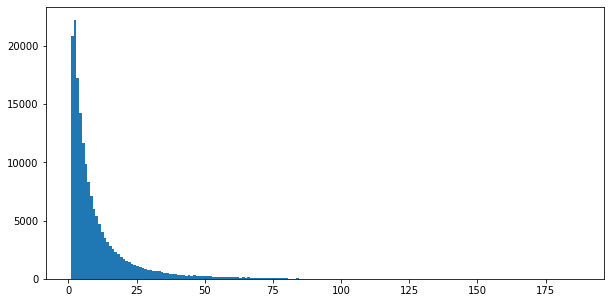

In [3]:
plt.figure(figsize=(10,5))
plt.hist(x=train['hindex'],bins=187)

**selection of sub-dataset with same distribution than the original**

In [4]:
data_path = "../tmp/data_10000.csv"
data = preprocessing_for_fastText(10000,train)
data.to_csv(data_path,index=None)
data = pd.read_csv(data_path)
data = small_class(data, 6)
data.head()

,author,hindex,text,nb_paper,mean_coauthors_hindex,n_coauthors,modindx,hindex_lab
0,2192797973,15.0,we present newly collected data set of gold st...,5,12.000000,6,6.0,__label__6.0
1,2568812976,4.0,problem to be solved to provide tv system for ...,5,16.500000,2,4.0,__label__4.0
2,2159374572,24.0,this paper presents novel engine coined topx f...,5,16.716981,53,6.0,__label__6.0
3,2745744053,22.0,this paper describes coherent optical orthogon...,5,16.000000,4,6.0,__label__6.0
4,2127692187,18.0,method for real time detection of denial of se...,4,15.666667,3,6.0,__label__6.0


In [5]:
data.describe()

,author,hindex,nb_paper,mean_coauthors_hindex,n_coauthors,modindx
count,9.796000e+03,9796.000000,9796.000000,9796.000000,9796.000000,9796.000000
mean,1.993336e+09,9.841160,3.977338,15.514139,9.563699,4.386178
std,6.393600e+08,12.055575,1.323559,11.152517,39.555898,1.890577
min,1.139156e+07,1.000000,1.000000,1.000000,0.000000,1.000000
25%,2.019859e+09,3.000000,3.000000,8.000000,2.000000,3.000000
50%,2.133884e+09,6.000000,5.000000,12.500000,3.000000,6.000000
75%,2.286076e+09,12.000000,5.000000,20.000000,6.000000,6.000000
max,2.908001e+09,163.000000,5.000000,131.000000,930.000000,6.000000


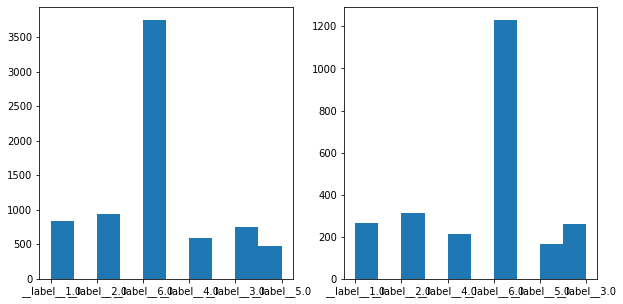

In [6]:
train1,test1 = train_test_split(data,random_state=1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1).hist(train1['hindex_lab'])
plt.subplot(1,2,2).hist(test1['hindex_lab']);

In [7]:
train_path = "../tmp/train.txt"
test_path = "../tmp/test.txt"

df_to_txt(train1,train_path)
df_to_txt(test1,test_path)

### Utilisation de Fast text

In [8]:
model0 = fasttext.train_supervised(train_path)

Read 4M words
Number of words:  68513
Number of labels: 6
Progress: 100.0% words/sec/thread: 4794808 lr:  0.000000 avg.loss:  1.442847 ETA:   0h 0m 0s


In [9]:
train_duration = 60 # in seconds
model1 = fasttext.train_supervised(train_path, autotuneValidationFile=test_path, autotuneDuration=train_duration)

Progress: 100.0% Trials:    9 Best score:  0.569212 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  68513
Number of labels: 6
Progress: 100.0% words/sec/thread: 4881640 lr:  0.000000 avg.loss:  1.116733 ETA:   0h 0m 0s


In [10]:
model0.test(test_path)

(2449, 0.504287464271131, 0.504287464271131)

In [11]:
model1.test(test_path)

(2449, 0.5667619436504696, 0.5667619436504696)

In [12]:
comp = pd.DataFrame({'paramètre':['hidden layer','learning rate','epoch','loss'],'model0':[model0.dim,model0.lr,model0.epoch,model0.loss],'model1':[model1.dim,model1.lr,model1.epoch,model1.loss]})
comp

,paramètre,model0,model1
0,hidden layer,100,54
1,learning rate,0.1,0.078425
2,epoch,5,39
3,loss,loss_name.softmax,loss_name.softmax


In [13]:
comp =general_comp(model1,test1)
comp.head()

,test_pred_lab,test_pred_prob,author,hindex,text,nb_paper,mean_coauthors_hindex,n_coauthors,modindx,hindex_lab
0,__label__6.0,0.958925,2396441528,1.0,temporal and spatial localities are basic conc...,2,6.500000,2,1.0,__label__1.0
4,__label__2.0,0.246948,2308460797,4.0,the internet of things iot represents the curr...,5,16.000000,2,4.0,__label__4.0
6,__label__2.0,0.271152,2799533387,1.0,castellanii ac are ubiquitously distributed in...,2,7.500000,2,1.0,__label__1.0
10,__label__1.0,0.608549,2097906641,2.0,this manual describes prolog system developed ...,2,4.000000,1,2.0,__label__2.0
13,__label__2.0,0.239596,2302754731,7.0,much research in the last few years has been d...,5,7.166667,6,6.0,__label__6.0


**exploitation de model**

In [14]:
from scipy.special import softmax
dictionnaire = model1.get_words()
model1.get_word_id("hello")
len(dictionnaire)
A = model1.get_input_matrix()
B = model1.get_output_matrix()
repthe = model1.get_sentence_vector(comp.iloc[1,4])
softthe = repthe@B.T
print(softmax(softthe))
model1.predict(comp.iloc[1,4],k=6)

[0.22729461 0.24693842 0.08981353 0.19427438 0.13726646 0.10441248]


(('__label__2.0',
  '__label__6.0',
  '__label__3.0',
  '__label__4.0',
  '__label__5.0',
  '__label__1.0'),
 array([0.24694842, 0.22730467, 0.19428441, 0.1372765 , 0.10442249,
        0.08982355]))

On est sur que le modèle applique softmax sur la représentation du mot. Nous ou choisit donc d'appliquer un autre régresseur

**Data for multiple regression model**

In [15]:
def reg_data(train, test):
    X_train = np.zeros((train.shape[0], model1.dim))
    set_rep = train["text"].apply(lambda x: model1.get_sentence_vector(x))
    X_train = np.array(set_rep.to_list())
    nb_train = np.array(train["nb_paper"].to_list()).reshape(-1, 1)
    coauthors_hindex_train = np.array(train["mean_coauthors_hindex"].to_list()).reshape(-1, 1)
    n_coauthors_train = np.array(train["n_coauthors"].to_list()).reshape(-1, 1)
    X_train = np.concatenate((X_train, nb_train, coauthors_hindex_train, n_coauthors_train), axis=1)
    # X_train = np.concatenate((X_train, nb_train), axis=1)

    X_test = np.zeros((test.shape[0], model1.dim))
    set_rep = test["text"].apply(lambda x: model1.get_sentence_vector(x))
    X_test = np.array(set_rep.to_list())
    nb_test = np.array(test["nb_paper"].to_list()).reshape(-1, 1)
    coauthors_hindex_test = np.array(test["mean_coauthors_hindex"].to_list()).reshape(-1, 1)
    n_coauthors_test = np.array(test["n_coauthors"].to_list()).reshape(-1, 1)
    X_test = np.concatenate((X_test, nb_test, coauthors_hindex_test, n_coauthors_test), axis=1)
    # X_test = np.concatenate((X_test, nb_test), axis=1)

    y_train = np.array(train["hindex"].to_list())
    y_test = np.array(test["hindex"].to_list())
    return X_train, X_test, y_train, y_test


In [31]:
X_train,X_test,y_train,y_test = reg_data(train1,test1)

**Random forest**

In [17]:
print(X_train.shape)
print(X_test.shape)

(7347, 57)
(2449, 57)


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

In [33]:
mod_preds = forest_model.predict(X_test)

In [34]:
mean_squared_error(y_test,mod_preds)

84.12852196815027

In [21]:
y_train.max()

160.0

**test svm**

In [22]:
from sklearn.svm import SVC

model_svm =SVC(kernel='sigmoid', C=2)

In [23]:
model_svm.fit(X_train,y_train)

SVC(C=2, kernel='sigmoid')

In [24]:
svm_pred = model_svm.predict(X_test)

In [25]:
mean_squared_error(y_test,svm_pred)

138.69211923233973

**Test CNN**

In [26]:
# mlp = MLP